## Kelley hu4d5-5 VL-F53N error analysis

In this notebook we will use a random forest model to find the most energetically influential degrees of freedom for the VL-F53N TI production run. Next, we will compare the sampling of these DOF during TI production to a free energy profile derived from end state GaMD sampling. We will attempt to correct any inaccurate sampling in the TI data and find the estimated ddG before and after the correction. 

In [1]:
import os
os.chdir("..")
from common_functions import *

### Ingesting original TI lambda production data 

In [2]:
os.chdir("./TI_data/VL-F53N/")
geom_dvdls = pd.read_csv("F53N_bound.csv")
dvdls_ub = pd.read_csv("F53N_unbound.csv")

### Original ddG estimate:

In [3]:
orig_dG_bd = geom_dvdls.groupby("Lambda").mean().sum()["weight_dvdl"]
orig_dG_ubd = dvdls_ub.groupby("Lambda").mean().sum()["weight_dvdl"]

empirical_value = 1.19
orig_error = abs((orig_dG_bd - orig_dG_ubd) - empirical_value)

print("Original ddG estimate: ")
print(f"{round(orig_dG_bd - orig_dG_ubd, 5)} kcal/mol ")
print()
print("Original ddG error: ")
print(f"{round(orig_error, 5)} kcal/mol")

Original ddG estimate: 
-0.55664 kcal/mol 

Original ddG error: 
1.74664 kcal/mol


### Splitting data into independent/dependent variables for random forest model

See our methods/supplemental methods section for our process to choose the input features. We are also removing correlated variables among candidate degrees of freedom - this is important because we want to limit the noise in our model training. 

In [18]:
X = geom_dvdls.drop([
    "#Frame", "weight_dvdl", "dvdl", "Run", "Lambda", "Y404_chi2", "E410_chi2", "N120_N570"
], axis=1)

Y = geom_dvdls["weight_dvdl"]


X_scl = pd.DataFrame(StandardScaler().fit_transform(X))
X_scl.columns = X.columns


### Checking to see if there is any cross-correlations within the dataset

In [19]:
absCorr = abs(X_scl.corr())
for i in absCorr.columns:
    for j in absCorr.index:
        cor = absCorr.loc[i, j]
        if abs(cor) > 0.5 and i != j:
            print(i, j)
            print(cor)
            

### Using random forest model to identify the most influential degrees of freedom

We run our model 25 times, then sort the results by the mean of feature importance across the 25 iterations. Here, it appears that the hydrogen bond between Ag-C117 and the VL-N53 side chain (softcore region residue) has a major influence on DV/DL.

However, we will see that it is extremely difficult to get the VL-N53 to sample this hydrogen bond while still accomodating the bulky side chain VL-F53.

In [20]:
rfeDefault = RFE(estimator=DecisionTreeRegressor(max_depth=5, random_state=42), n_features_to_select=0.75, step=0.05)
rfDefault = RandomForestRegressor(
    max_depth=10, n_estimators=200, oob_score=True, max_features=0.6, min_samples_leaf = 7, min_samples_split=14, random_state=42
)

pipelineDefault_rf = Pipeline([
    ('feature_scaling', StandardScaler()),
    # ('pre_select', kbest),
    ('feature_selection', rfeDefault),
    ('regression_model', rfDefault)
])


imps = benchmark_model(pipelineDefault_rf, X_scl, Y, geom_dvdls["Lambda"])
imps[["Mean", "Median"]].sort_values(by="Mean", ascending=False)[:15]

0.7583284428791573
0.0005252845673902187
0.6373263509315543
0.004133450057708384


,Mean,Median
C117_N570,0.265141,0.265075
N570_chi1,0.122750,0.122640
N570_chi2,0.083395,0.083391
N120_chi2,0.082876,0.099780
N120_chi1,0.077424,0.075178
F408_chi1,0.076963,0.088921
F408_chi2,0.046312,0.035641
I104_chi1,0.046233,0.046889
Y404_chi1,0.037079,0.051049
S407_chi1,0.034838,0.025852


### Comparing GaMD pmf with TI rotamers

The plot indicates that during TI, the sampled conformations were wholly different from what was deemed most energetically favorable for the VL-N53 end state. It is very difficult to perform any GaMD-based filtering correction for this since there are zero TI frames that fall within the energetically favorable region of the GaMD pmf. 

When we tried to use NMR restraints to constrain the hydrogen bond distance between VL-N53 and Ag-C117, the complex quickly would unbind since it is extremely difficult for the system to accomodate the hydrogen bond and also have enough space for the bulky VL-F53 side chain. 

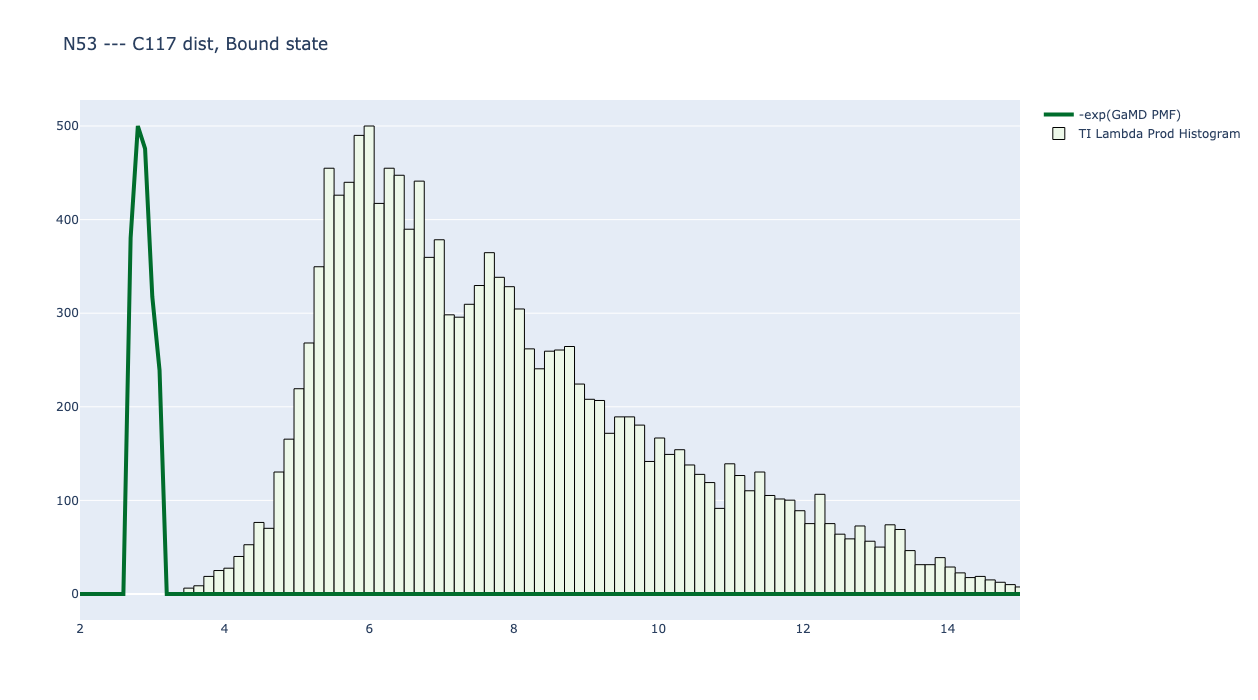

In [6]:
os.chdir("../../gamd_pmfs/VL-F53N")
N53_C117 = get_pmf(
    "pmf-c2-N53_C117_conv_300ns.dat.xvg"
)

plot_pmf_TI_1D_fig(N53_C117, geom_dvdls, "C117_N570", 500, 120).update_layout(
    title = "N53 --- C117 dist, Bound state", width=1000, height=700).update_xaxes(range=[2, 15]).show(renderer="jupyterlab")
